In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-object-detection/data/sample_submission.csv
/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv
/kaggle/input/car-object-detection/data/testing_images/vid_5_26420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31520.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31720.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_26560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_27840.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28360.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29020.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_30720.jpg
/kaggle/

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [5]:
df.columns

Index(['image', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [6]:
# Paths
img_dir = '/kaggle/input/car-object-detection/data/training_images/'
csv_path = '/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv'

# Load annotation CSV
df = pd.read_csv(csv_path)

def extract_color_histogram(image, bins=(8,8,8)):
    # Convert to HSV and compute a 3D color histogram then normalize
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Collect positive samples (car patches) and negative samples (random patches)
pos_features = []
neg_features = []

# Limit to 100 images for speed
image_ids = df['image'].unique()[:100]

for image_id in image_ids:
    img_path = os.path.join(img_dir, image_id)
    img = cv2.imread(img_path)
    if img is None:
        # Image file not found or can't be read
        print(f"Warning: Could not read image {image_id}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get car bounding boxes for this image
    boxes = df[df['image'] == image_id][['xmin','ymin','xmax','ymax']].values

    # Extract features for each car patch
    for (xmin, ymin, xmax, ymax) in boxes:
        # Convert to int for slicing
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

        # Make sure bounding box is within image bounds
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(img.shape[1], xmax)
        ymax = min(img.shape[0], ymax)

        patch = img[ymin:ymax, xmin:xmax]
        if patch.size == 0:
            continue
        feat = extract_color_histogram(patch)
        pos_features.append(feat)

    # Extract random negative patches from image (non-car)
    h, w = img.shape[:2]
    for _ in range(len(boxes)):  # same number negative patches
        x = np.random.randint(0, w - 50)
        y = np.random.randint(0, h - 50)
        patch = img[y:y+50, x:x+50]
        feat = extract_color_histogram(patch)
        neg_features.append(feat)

In [7]:
# Create dataset
X = np.array(pos_features + neg_features)
y = np.array([1]*len(pos_features) + [0]*len(neg_features))  # 1 = car, 0 = background

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        28

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



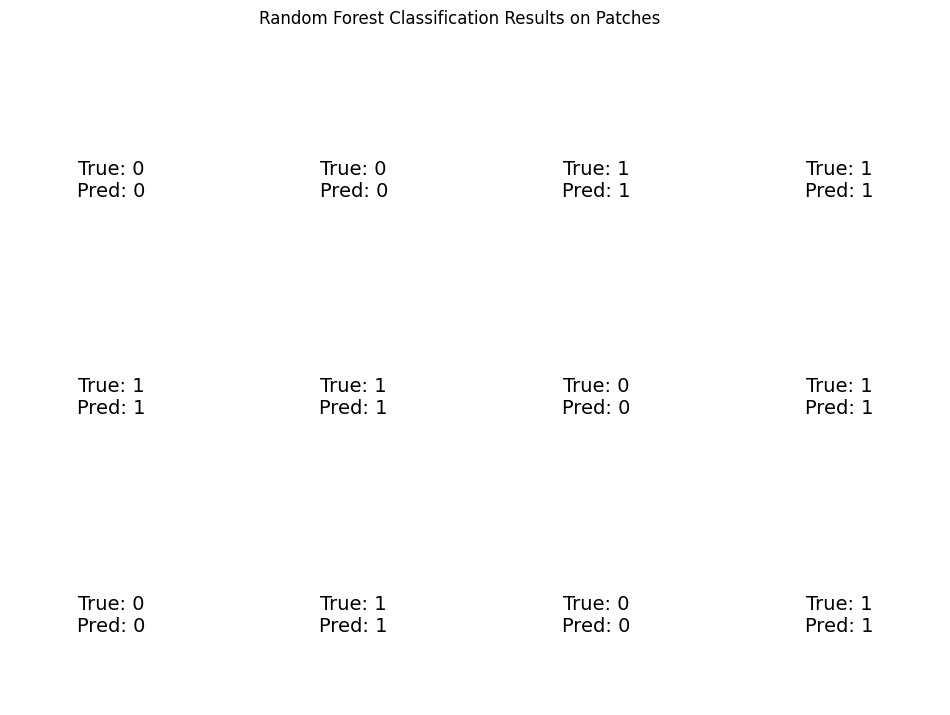

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    idx = np.random.randint(len(X_test))
    sample_feat = X_test[idx]
    true_label = y_test[idx]
    pred_label = clf.predict([sample_feat])[0]

    # We cannot recover image patch from histogram easily,
    # so just show label info here.
    ax.text(0.5, 0.5, f"True: {true_label}\nPred: {pred_label}", 
            fontsize=14, ha='center', va='center')
    ax.axis('off')

plt.suptitle('Random Forest Classification Results on Patches')
plt.show()